# Deep Learning für Visual Computing: Übungsblatt 08

**Von: Maximilian Mundt, Radmehr Nouri Inanlou**

**Abgabe: 15.06.2022**

Das hier ist der zweite, praktische Teil der Übungsblattkombo 07 und 08. Wir haben die Datei `visualize.py` etwas abgeändert (wenn auch sehr unschön), da wir immer mal wieder auf ein paar Unverträglichkeiten mit unserem Code gestoßen sind, ansonsten sind alle Abgaben in dem Notebook hier und in `handout.py`. Trainiert haben wir unser Netzwerk diesmal mit einer Grafikkarte (Gtx 1660 Super), deswegen auch das ganze to_device-Zeug. Das Modell haben wir in `model.pt` gespeichert und kann auch so standardmäßig hier im Notebook genutzt werden. Die Loss-History mussten wir als Bild speichern, da wir die nicht im Modell gespeichert haben.

Abgesehen von dem vorgesehenen Test-Datensatz, haben wir auch noch 6 eigene Bilder am Ende durchs Netzwerk geschickt, um zu sehen, um was es sich da so handelt :)

In [1]:
from handout import (
    create_augmented_dataset,
    train,
    evaluate,
    to_device,
    CIFAR10Classifier,
)
from visualize import show_loss_curve, show_image_grid
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
import torch

# torch.cuda.empty_cache()

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASSES = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

train_data = create_augmented_dataset(train=True)
# train_data = Subset(train_data, torch.arange(5000))
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

test_data = create_augmented_dataset(train=False)
test_dataloader = DataLoader(test_data, batch_size=25, shuffle=False)

print("Items in train set:", len(train_data))
print("Items in test set:", len(test_data))


Files already downloaded and verified
Files already downloaded and verified
Items in train set: 50000
Items in test set: 10000


## a) Dataset Augmentation

Die Lösungen hierzu sind in der Funktion `create_augmented_dataset()` in `handout.py`. Wir haben jetzt einfach mal 2 Transformationen genommen. Einmal eine Rotation um maximal 30 Grad und eine horizontale Spiegelung. Hier hätte man sicherlich noch mehr Transformationen nehmen können, z.B. Perspektivwechsel, Zooms oder Crops, wir wollten's hier aber nicht übertreiben.

Hier sieht man deutlich, dass einige Bilder um ein paar Grad rotiert sind. Die Spiegelung kann man hier so natürlich nicht beurteilen, aber sie sollte auch da sein.

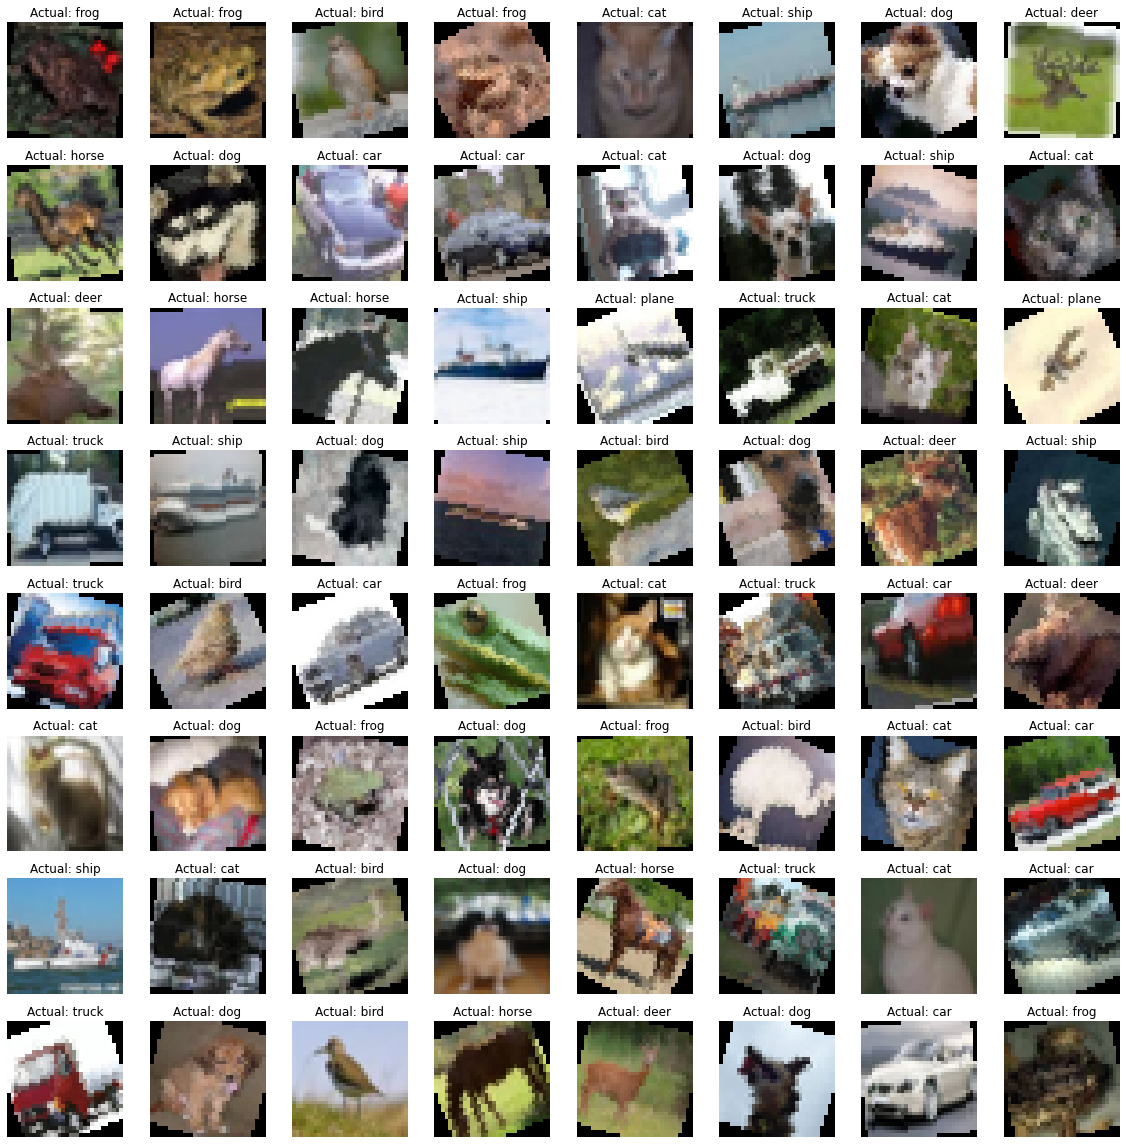

In [6]:
sample_iterator = iter(train_dataloader)
images, labels = next(sample_iterator)
show_image_grid(images, labels)

## b) Klassifizierung mit Convolutional Networks

Wie erwähnt, haben wir unser Modell gespeichert und kann so benutzt werden. Die Struktur des Netzes sollte wieder ungefährt dem VGG-Net entsprechen, also solche "Conv-Blöcke" mit jeweils zwei Convolutional Layers, Batch Norm und ReLU, und nach jedem Block ein Max Pool Layer. Nach den konvolutionalen Teil kommen dann noch zwei fully-connected Layer. Wir haben die Struktur soweit angepasst, dass wir mit unseren Parametern nicht über 1.8 Millionen kommen, ansonsten haben wir uns da jetzt nicht die mega Gedanken gemacht, einfach ein bisschen herumprobiert.

Was den Rest angeht: Wir haben den Adam Optimizer gewählt, weil man damit gefühlt immer anfängt und ansonsten gab es nicht viel zu verändern. Am Anfang kamen wir auf ~ 70 Prozent Genauigkeit, von da war es dann ein wenig schwierig, alles zu verbessern. Am Ende haben uns dann aber die 50 Epochen gerettet. Die Batch Size 64 hat einfach dem Gefühl nach am besten geklappt. :)

Die Trainings und Evaluierungsmethode in `handout.py` sind hoffentlich logisch und selbsterklärend aufgeschrieben.

In [9]:
# model = CIFAR10Classifier().to(DEVICE)

# history = train(model=model, dataloader=train_dataloader, epochs=50, save=True)
# show_loss_curve(history)

model = torch.load("model.pt").to(DEVICE)
model.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 31, 31]               0
            Conv2d-8          [-1, 128, 31, 31]          73,856
       BatchNorm2d-9          [-1, 128, 31, 31]             256
             ReLU-10          [-1, 128, 31, 31]               0
           Conv2d-11          [-1, 128, 31, 31]         147,584
      BatchNorm2d-12          [-1, 128, 31, 31]             256
             ReLU-13          [-1, 128, 31, 31]               0
        MaxPool2d-14          [-1, 128,

Hier gehen wir nach dem Training mal eine Test-Batch durch, um einen Eindruck davon zu bekommen, wie unser Netzwerk performed. Scheint eigentlich ganz gut zu sein :)

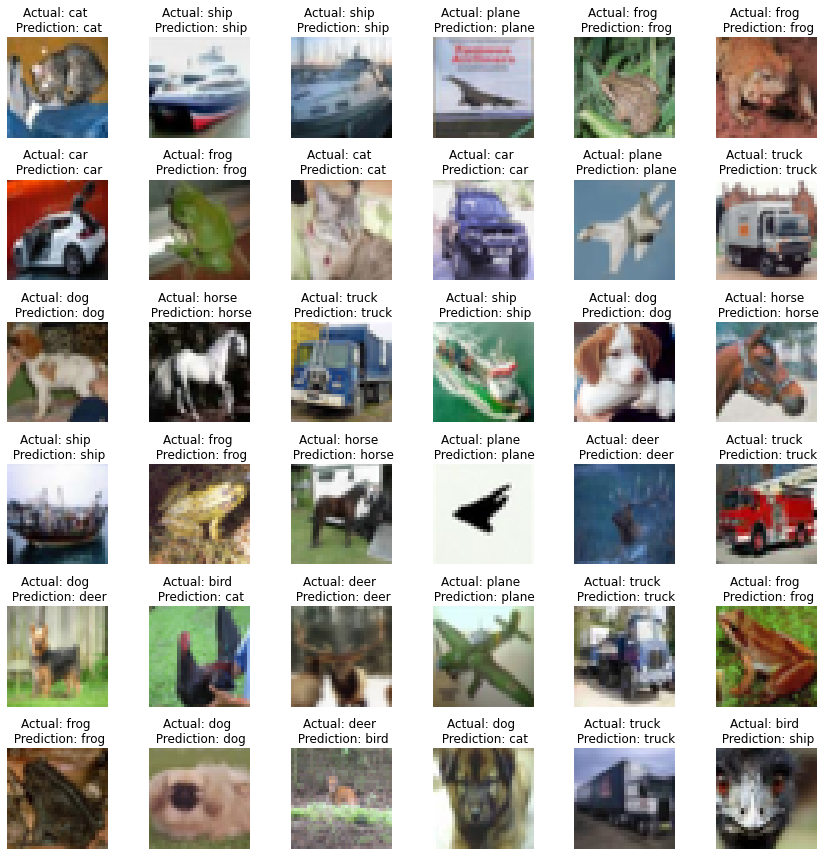

In [19]:
test_iterator = iter(test_dataloader)
images, labels = to_device(next(test_iterator), DEVICE)

with torch.no_grad():
    predictions = model(images)
    predictions_as_labels = torch.argmax(predictions, 1)

    show_image_grid(images, labels, predictions_as_labels)

Hier dann nun die Accuracy, die Methode dazu ist auch in `handout.py`. Das Training hat um die 40 min gedauert mit 50 Epochen, wobei man da vielleicht sogar hätte früher abbrechen können. Zum Glück sind wir hier knapp auf die 85% gekommen!

In [20]:
acc = evaluate(model, test_dataloader)
print(f"Accuracy for test data: {acc}%")

Accuracy for test data: 85.43%


Wie erwähnt, hier unsere eigenen Random Bilder aus der Handy-Gallerie in einer Klasse `CustomTestDataset`. Die `__getitem__` und `__len__` Methoden sind hier eigentlich überflüssig, da wir keinen Dataloader nutzen, aber vielleicht kommen da ja irgendwann noch hunderte Bilder hinzu... 

In [11]:
from PIL import Image
from pathlib import Path

class CustomTestDataset():
    def __init__(self):
        custom_data_path = Path("./custom_data")
        
        self.images = torch.empty(0, 3, 32, 32)
        self.labels = torch.empty(0, dtype=torch.int32)

        for file in custom_data_path.iterdir():
            label = CLASSES.index(file.stem.split("_")[-1])
            transform = transforms.Compose([
                transforms.Resize(size=(32, 32)),
                transforms.ToTensor()
            ])
            image = transform(Image.open(file)).unsqueeze(0)

            self.images = torch.cat((self.images, image))
            self.labels = torch.cat((self.labels, torch.IntTensor([label])))

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.images)

Beim ersten könnte man sich streiten, ob es sich hier wirklich um einen Frosch handelt :/

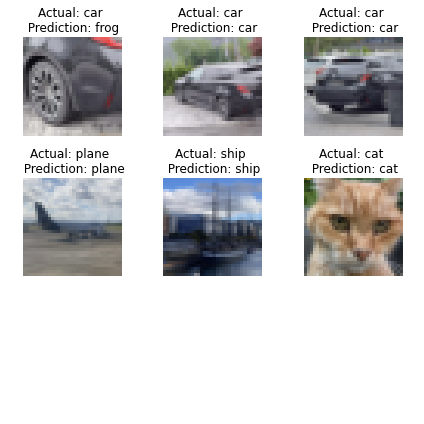

In [12]:
custom_data = CustomTestDataset()

with torch.no_grad():
    predictions = model.cpu()(custom_data.images)
    predictions_as_labels = torch.argmax(predictions, 1)

    show_image_grid(custom_data.images, custom_data.labels, predictions_as_labels)


Sonst gibt es wahrscheinlich nicht mehr so viel zu sagen. Die Aufgabe war im Vergleich zu den anderen sehr cool, da man hier mal wirklich ein Ziel hatte und auch direkt die Ergebnisse gesehen hat.

Wir haben hier jetzt natürlich nur einen Durchlauf mit den 85% gemacht, aber wir sind zuversichtlich, dass das auch mit den anderen Läufen geklappt hätte, die ganzen Testläufe davor waren zumindest auch immer sehr konstant.